## Compare ECCO and ERA5 net air-sea heat fluxes

In [12]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import cmocean
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Open ECCO heat flux data

In [2]:
# define root directory for location of all downloaded NetCDF files
root_dir = Path('../data/ECCO_V4r4_PODAAC')

# define the directory where the files specific to desired dataset are stored
nc_heat_dir = root_dir / "ECCO_L4_HEAT_FLUX_05DEG_MONTHLY_V4R4"

In [3]:
# get all files in each folder for import
heat_nc_files = list(nc_heat_dir.glob('*nc'))

In [79]:
# import 26 years of ecco heat flux data
ecco_heat_ds = xr.open_mfdataset(heat_nc_files, parallel=True, data_vars='minimal',\
                            coords='minimal', compat='override')

ecco_heat_ds

<xarray.Dataset>
Dimensions:         (time: 312, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T...
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    latitude_bnds   (latitude, nv) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
    longitude_bnds  (longitude, nv) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    EXFhl           (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFhs           (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFlwdn         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFswdn         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFqnet         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    oceQnet         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SIatmQnt        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    TFLUX           (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFswnet        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFlwnet        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    oceQsw          (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SIaaflux        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Ocean and Sea-Ice Surface Heat Fluxes ...
    uuid:                         73ea7d5c-4158-11eb-8d61-0cc47a3f812d

In [5]:
# import the geometry data file that provides area and volume information for grid cells
geometry_ds = xr.open_dataset('../data/ECCO_V4r4_PODAAC/ECCO_L4_GEOMETRY_05DEG_V4R4/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc')
geometry_ds

<xarray.Dataset>
Dimensions:         (Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    latitude_bnds   (latitude, nv) float32 ...
    longitude_bnds  (longitude, nv) float32 ...
    Z_bnds          (Z, nv) float32 ...
Dimensions without coordinates: nv
Data variables:
    hFacC           (Z, latitude, longitude) float64 ...
    Depth           (latitude, longitude) float64 ...
    area            (latitude, longitude) float64 ...
    drF             (Z) float32 ...
    maskC           (Z, latitude, longitude) bool ...
Attributes: (12/57)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the 0.5 deg...
    uuid:                            b4795c62-86e5-11eb-9c5f-f8f21e2ee3e0

In [6]:
# pull out Depth from geometry file to use for creating the mask
ecco_depth = geometry_ds.Depth

In [7]:
# meshgrid for longitude and latitude 1D arrays
data_x_mg, data_y_mg = np.meshgrid(ecco_depth.longitude,ecco_depth.latitude)

In [8]:
# create mask of subpolar gyre using 2000 m contour north of 55 deg.
# the last two logical statements remove small boxes from the desired region
gyre_mask = np.where(ecco_depth > 2000, 1, np.nan)*np.where(np.logical_and(data_y_mg > 55, data_y_mg < 70), 1, np.nan)*\
            np.where(data_x_mg > -60, 1, np.nan)*np.where(data_x_mg < -29, 1, np.nan)*\
            np.where(np.logical_and(data_y_mg < 58.5, data_x_mg > -34), np.nan, 1)*\
            np.where(np.logical_and(data_y_mg < 55.5, data_x_mg > -35), np.nan, 1)

In [101]:
gyre_mask_da = xr.DataArray(gyre_mask, dims=("latitude","longitude"),\
                            coords=dict(latitude=heat_ds.EXFqnet.latitude,longitude=heat_ds.EXFqnet.longitude),\
                            name='mask')

In [84]:
# multiply ecco heat flux by mask to isolate data for the subpolar gyre 
ecco_EXFqnet_gyre_da = ecco_heat_ds.EXFqnet*gyre_mask_da

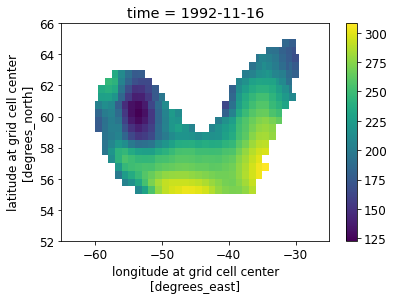

In [72]:
# sanity check plot to make sure the mask worked
ecco_EXFqnet_gyre.isel(time=10).plot()
plt.xlim(-65,-25)
plt.ylim(52,66);

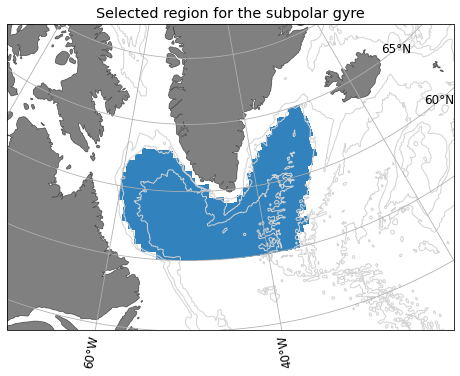

In [63]:
# Plot region selected for analysis
plt.rcParams['font.size'] = 12
fig = plt.figure(figsize=[8,10])

ax1=plt.subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude=-50))
ax1.set_extent([-70, -20, 50, 70], ccrs.PlateCarree()) # Limit the map extent
ax1.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=0.2)
ax1.add_feature(cfeature.LAND, color='gray')
bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax1.add_feature(bathym, facecolor='none', edgecolor='lightgray')
bathym = cfeature.NaturalEarthFeature(name='bathymetry_I_2000', scale='10m', category='physical')
ax1.add_feature(bathym, facecolor='none', edgecolor='lightgray')
bathym = cfeature.NaturalEarthFeature(name='bathymetry_H_3000', scale='10m', category='physical')
ax1.add_feature(bathym, facecolor='none', edgecolor='lightgray', label=True)

gl = ax1.gridlines(draw_labels=True)

gl.top_labels=False

data_cartopy_crs = ccrs.PlateCarree()
ecco_EXFqnet_gyre.isel(time=100).plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='tab20c',vmin= -1, vmax=1,add_colorbar=False)
                         
ax1.set_title("Selected region for the subpolar gyre");

In [137]:
def calc_winter_Qnet(qnet_da, years, mask_da):
    """
    Function to calculate area-weighted air-sea heat fluxes. Can be easily modified to other datasets for wintertime means.
    
    `qnet_da` is a DataArray containing all heat flux data that includes lat and lon coordinates
    `years` is a list of years (e.g., list(range(1992, 2017, 1))) over which you want to calculate winter heat fluxes
    `mask` is a DataArray that defines the area within the dataset to be used for calculations and weight-averages
    
    """
    # loop through each year and calculate only winter season (Nov-Mar) heat fluxes
    heat_winter = []
    
    for year in years:
        # subset data for winter season using consecutive years and take mean
        data_tmp = qnet_da.sel(time=slice('11-'+str(year),'03-'+str(year+1)))
        
        # cos(lat) is proportional to grid cell area
        cos_lat = np.cos(np.deg2rad(data_tmp.latitude))
        weights_lon, weights_lat = np.meshgrid(data_tmp.longitude, cos_lat)
        weights = xr.DataArray(weights_lat*mask_da, dims=("latitude","longitude"),\
                               coords=dict(latitude=data_tmp.latitude,longitude=data_tmp.longitude),name='weights')
        qnet_weighted = (data_tmp*weights).sum(dim=["latitude","longitude"])/weights.sum()
        winter_heat = qnet_weighted.mean(dim=["time"])
        # assign to output
        heat_winter.append(winter_heat.values)
    
    # Create output DataArray
    winter_heat_da = xr.DataArray(heat_winter, dims='start_year', coords={'start_year': years}, name='Qnet_winter')
    
    heat_avg_winter = winter_heat_da.mean()
    
    print(f'mean winter (Nov-Mar) air-sea heat flux 1992-2017: {heat_avg_winter.round(2).values} W m^-2\n')
    print(winter_heat_da)
    
    # plot winter mean heat flux
    plt.figure(figsize=[11, 5])
    plt.rcParams['font.size'] = '12'
    winter_heat_da.plot()
    # ticks
    year_span = []
    for year in winter_heat_da.start_year:
        year_span.append(str(year)[-2:]+'-'+str(year+1)[-2:])
    plt.margins(x=0)
    plt.grid(linestyle='-.', linewidth=0.5)
    plt.ylabel("$Q_{net}$ (Wm$^{-2}$)")
    plt.xticks(ticks=winter_heat_da.start_year, labels=year_span, rotation=45)
    plt.xlabel("year")
    plt.title("Area-weighted mean winter (Nov-Mar) net air-sea heat flux");
    
    return winter_heat_da, heat_avg_winter

mean winter (Nov-Mar) air-sea heat flux 1992-2017: 224.83 W m^-2

<xarray.DataArray 'Qnet_winter' (start_year: 25)>
array([302.96020752, 292.33229329, 278.63559666, 147.67159446,
       241.60664724, 217.29177999, 242.24969947, 258.64126046,
       205.85495617, 247.73113624, 211.79820885, 217.197308  ,
       242.65953721, 200.72937585, 211.69056367, 260.57720135,
       198.90764985, 138.63073922, 199.72819136, 239.79489015,
       167.37363356, 217.52088526, 248.74931359, 221.97220353,
       208.37612733])
Coordinates:
  * start_year  (start_year) int32 1992 1993 1994 1995 ... 2013 2014 2015 2016


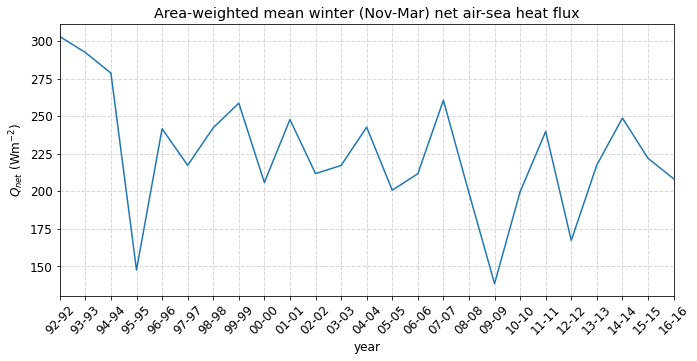

In [138]:
years = list(range(1992, 2017, 1))

ecco_winter_heat_da, ecco_heat_avg_winter = calc_winter_Qnet(ecco_EXFqnet_gyre_da, years, gyre_mask_da)

### Open ERA5 heat flux data

In [18]:
# inlcudes 1979-2021 variables: Surface net solar radiation, Surface net thermal radiation
solar_thermal = xr.load_dataset("../data_climatology/era5_1m_1979to2021_50to90N_-120Wto40E_025025_solar_thermal_heat.grib", engine='cfgrib')

Ignoring index file '../data_climatology/era5_1m_1979to2021_50to90N_-120Wto40E_025025_solar_thermal_heat.grib.923a8.idx' incompatible with GRIB file


In [19]:
# inlcudes 1979-2021 variables: Surface latent heat flux, Surface sensible heat flux
latent_sensible = xr.load_dataset("../data_climatology/era5_1m_1979to2021_50to90N_-120Wto40E_025025_latent_sensible_heat.grib", engine='cfgrib')

Ignoring index file '../data_climatology/era5_1m_1979to2021_50to90N_-120Wto40E_025025_latent_sensible_heat.grib.923a8.idx' incompatible with GRIB file


In [77]:
# The units are joules per square metre (J m^-2 ). 
# To convert to watts per square metre (W m^-2 ), the accumulated values should be divided by the accumulation period expressed in seconds.
# must divide values by 86,400 (sec/day)
era5_qnet_da = (solar_thermal.ssr/86400 + solar_thermal.str/86400 + latent_sensible.slhf/86400 + latent_sensible.sshf/86400)*(-1)

Need to put the ERA5 dataset on the same grid as the ECCO data in order to match the geometry mask for the gyre

In [146]:
era5_interp_da = era5_qnet_da.interp(latitude=ecco_heat_ds.latitude, longitude=ecco_heat_ds.longitude, method="nearest")
era5_qnet_da = era5_interp_da.sel(time=slice("1992","2017"))

In [103]:
era5_qnet_gyre_da = era5_qnet_da*gyre_mask_da

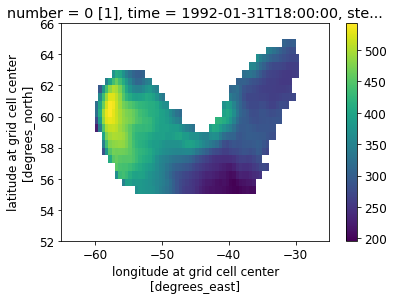

In [104]:
# sanity check plot
era5_qnet_gyre_da.isel(time=0).plot()
plt.xlim(-65,-25)
plt.ylim(52,66);

mean winter (Nov-Mar) air-sea heat flux 1992-2017: 170.69 W m^-2

<xarray.DataArray 'Qnet_winter' (start_year: 25)>
array([206.57642929, 197.74229203, 197.96585132, 132.18703734,
       198.24904331, 167.40541728, 167.44010029, 169.02698408,
       145.93053725, 187.64366732, 167.54296031, 147.97794912,
       170.21974578, 140.22047692, 157.48993012, 204.53073555,
       168.98546549,  94.22520948, 186.27820756, 172.30604817,
       132.25701366, 201.09285089, 214.7436258 , 162.85701116,
       176.39928955])
Coordinates:
  * start_year  (start_year) int32 1992 1993 1994 1995 ... 2013 2014 2015 2016


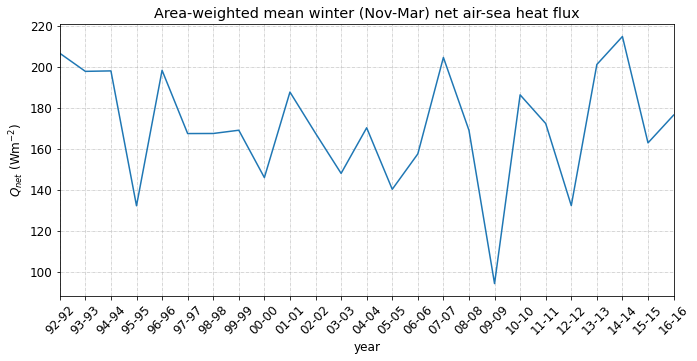

In [139]:
# run function for ERA5 data
era5_winter_heat_da, era5_heat_avg_winter = calc_winter_Qnet(era5_qnet_gyre_da, years, gyre_mask_da)

***

### Compare ERA5 and ECCO winter heat fluxes

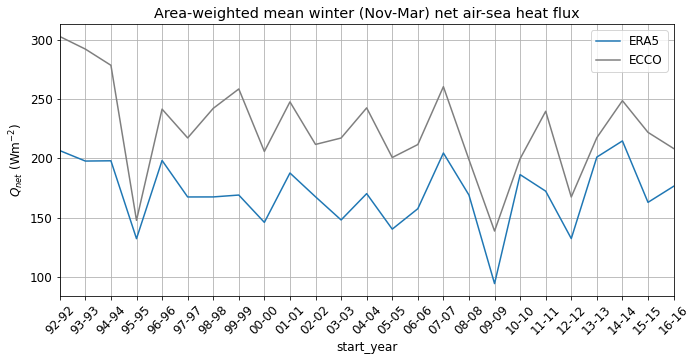

In [140]:
plt.figure(figsize=[11, 5])
plt.rcParams['font.size'] = '12'

era5_winter_heat_da.plot(color='tab:blue',label='ERA5')
ecco_winter_heat_da.plot(color='tab:gray',label='ECCO')

# ticks
year_span = []
for year in ecco_winter_heat_da.start_year:
    year_span.append(str(year)[-2:]+'-'+str(year+1)[-2:])

plt.margins(x=0)
plt.ylabel("$Q_{net}$ (Wm$^{-2}$)")
plt.xticks(ticks=era5_winter_heat_da.start_year, labels=year_span, rotation=45)
plt.title("Area-weighted mean winter (Nov-Mar) net air-sea heat flux")

plt.legend()
plt.grid();

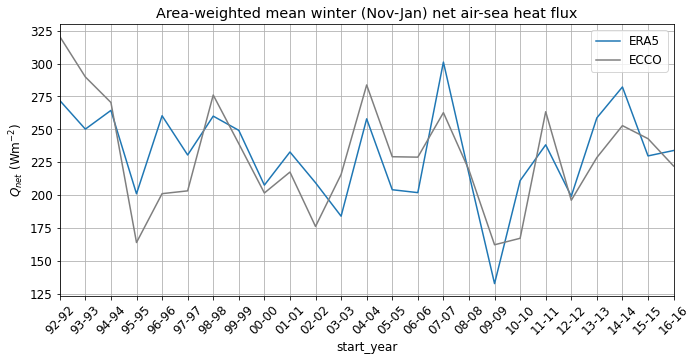

In [136]:
plt.figure(figsize=[11, 5])
plt.rcParams['font.size'] = '12'

era5_winter_heat_da.plot(color='tab:blue',label='ERA5')
ecco_winter_heat_da.plot(color='tab:gray',label='ECCO')

# ticks
year_span = []
for year in ecco_winter_heat_da.start_year:
    year_span.append(str(year)[-2:]+'-'+str(year+1)[-2:])

plt.margins(x=0)
plt.ylabel("$Q_{net}$ (Wm$^{-2}$)")
plt.xticks(ticks=era5_winter_heat_da.start_year, labels=year_span, rotation=45)
plt.title("Area-weighted mean winter (Nov-Jan) net air-sea heat flux")

plt.legend()
plt.grid();

In [125]:
# heat flux weighted by grid-cell area
area_gyre = geometry_ds.area*gyre_mask_da
area_gyre_total = area_gyre.sum(['latitude','longitude'])

EXFqnet_gyre_mean_weighted = (ecco_EXFqnet_gyre_da*area_gyre).sum(dim=["latitude","longitude"])/area_gyre_total

# now get the mean for each month from 1992-2017
EXFqnet_gyre_mean_month_weighted = EXFqnet_gyre_mean_weighted.groupby("time.month").mean(dim=["time"]) # average (same code as above)
EXFqnet_gyre_std_month_weighted = EXFqnet_gyre_mean_weighted.groupby("time.month").std(dim=["time"]) # standard dev

In [126]:
ecco_heat_months_ordered = xr.concat([EXFqnet_gyre_mean_month_weighted.sel(month=slice(5,12)),EXFqnet_gyre_mean_month_weighted.sel(month=slice(1,4))],dim='month')
ecco_heat_months_sd_ordered = xr.concat([EXFqnet_gyre_std_month_weighted.sel(month=slice(5,12)),EXFqnet_gyre_std_month_weighted.sel(month=slice(1,4))],dim='month')

In [127]:
ecco_heat_months_ordered['month'] = ['May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr']
ecco_heat_months_sd_ordered['month'] = ['May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr']

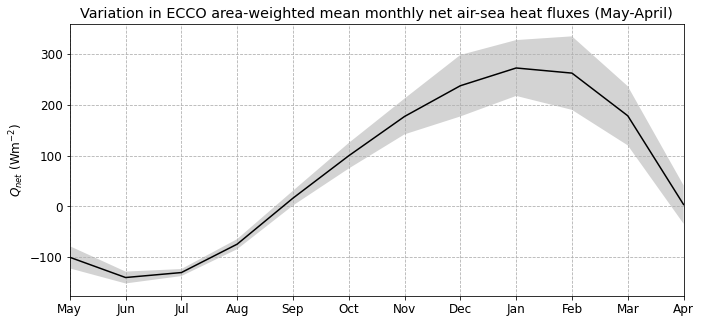

In [128]:
plt.figure(figsize=[11, 5])
plt.rcParams['font.size'] = '12'
plt.margins(x=0)

plt.plot(ecco_heat_months_ordered.month,ecco_heat_months_ordered.values, color='k')
plt.fill_between(ecco_heat_months_sd_ordered.month, ecco_heat_months_ordered.values-ecco_heat_months_sd_ordered.values,\
                 ecco_heat_months_ordered.values+ecco_heat_months_sd_ordered.values, facecolor='lightgray', interpolate=True)

plt.ylabel("$Q_{net}$ (Wm$^{-2}$)")
# plt.xticks(ticks=heat_months_ordered.month, labels=['M','J','J','A','S','O','N','D','J','F','M','A'])
plt.grid(linestyle='--')
plt.title("Variation in ECCO area-weighted mean monthly net air-sea heat fluxes (May-April)");

In [121]:
# heat flux weighted by grid-cell area
area_gyre = geometry_ds.area*gyre_mask_da
area_gyre_total = area_gyre.sum(['latitude','longitude'])

era5_gyre_mean_weighted = (era5_qnet_gyre_da*area_gyre).sum(dim=["latitude","longitude"])/area_gyre_total

# now get the mean for each month from 1992-2017
era5_gyre_mean_month_weighted = era5_gyre_mean_weighted.groupby("time.month").mean(dim=["time"]) # average
era5_gyre_std_month_weighted = era5_gyre_mean_weighted.groupby("time.month").std(dim=["time"]) # standard dev

In [122]:
era5_heat_months_ordered = xr.concat([era5_gyre_mean_month_weighted.sel(month=slice(5,12)),era5_gyre_mean_month_weighted.sel(month=slice(1,4))],dim='month')
era5_heat_months_sd_ordered = xr.concat([era5_gyre_std_month_weighted.sel(month=slice(5,12)),era5_gyre_std_month_weighted.sel(month=slice(1,4))],dim='month')

In [123]:
era5_heat_months_ordered['month'] = ['May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr']
era5_heat_months_sd_ordered['month'] = ['May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr']

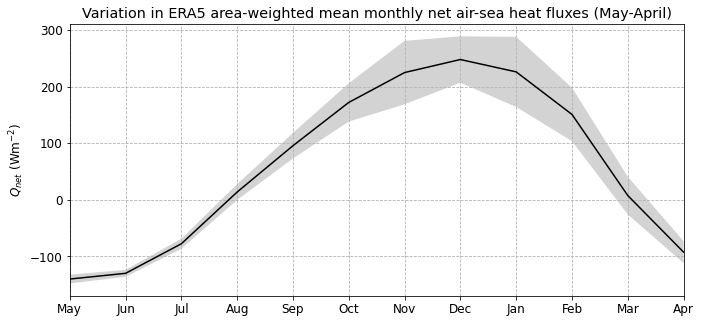

In [124]:
plt.figure(figsize=[11, 5])
plt.rcParams['font.size'] = '12'
plt.margins(x=0)

plt.plot(era5_heat_months_ordered.month,era5_heat_months_ordered.values, color='k')
plt.fill_between(era5_heat_months_ordered.month, era5_heat_months_ordered.values-era5_heat_months_sd_ordered.values,\
                 era5_heat_months_ordered.values+era5_heat_months_sd_ordered.values, facecolor='lightgray', interpolate=True)

plt.ylabel("$Q_{net}$ (Wm$^{-2}$)")
# plt.xticks(ticks=heat_months_ordered.month, labels=['M','J','J','A','S','O','N','D','J','F','M','A'])
plt.grid(linestyle='--')
plt.title("Variation in ERA5 area-weighted mean monthly net air-sea heat fluxes (May-April)");

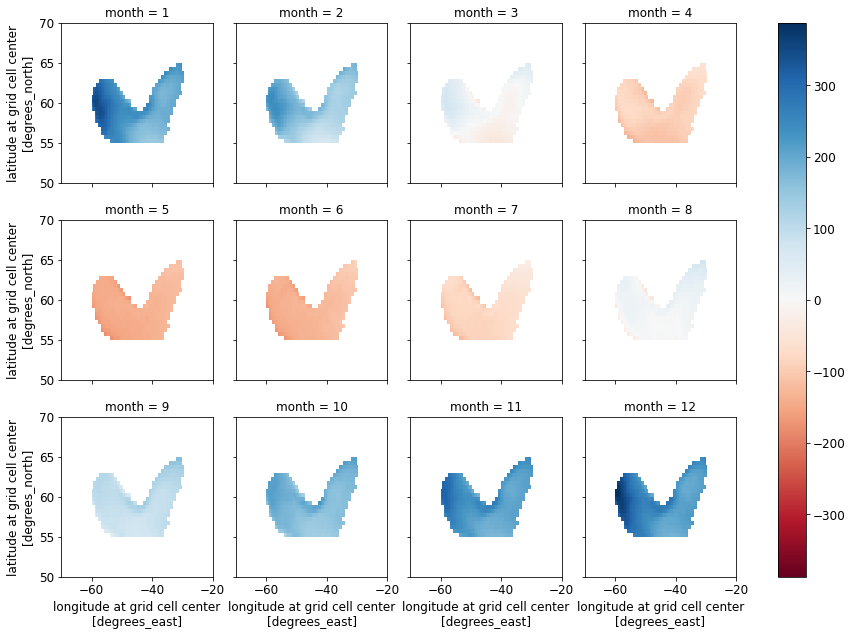

In [129]:
era5_qnet_gyre_da.sel(latitude=slice(50,70), longitude=slice(-70,-20)).groupby("time.month").mean("time").plot(x="longitude",y="latitude",col="month",col_wrap=4,cmap='RdBu');

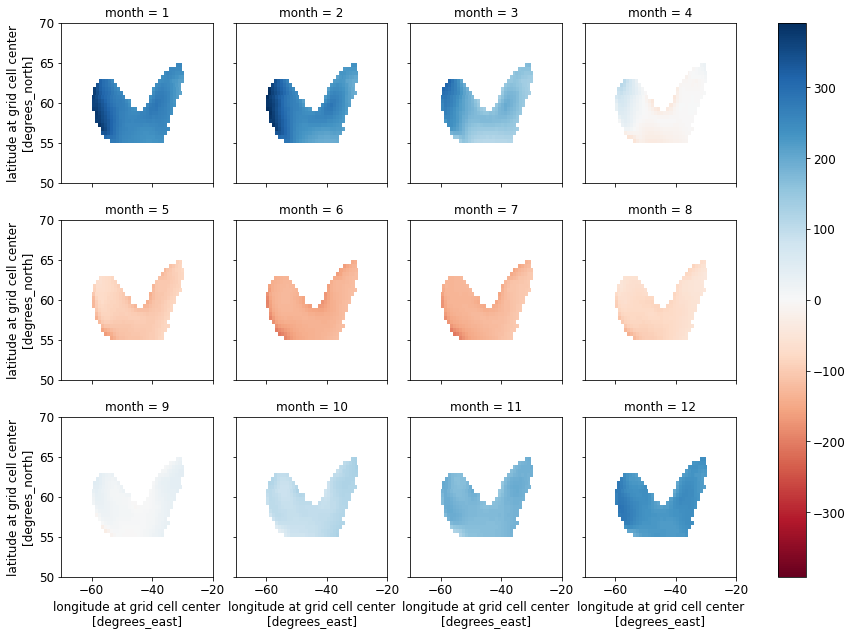

In [131]:
ecco_EXFqnet_gyre_da.sel(latitude=slice(50,70), longitude=slice(-70,-20)).groupby("time.month").mean("time").plot(x="longitude",y="latitude",col="month",col_wrap=4,cmap='RdBu');